# Parameter-Shift法
解説記事は[こちら](https://www.investor-daiki.com/it/qiskit-parameter-shift)をご覧ください。

In [1]:
import numpy as np
import matplotlib as plt
%matplotlib inline

題材は[QHACK2021で使用された問題](https://github.com/XanaduAI/QHack2021/blob/main/QML_Challenges/quantum_gradients_100_template/problem.pdf)を使用します。

入力パラメータ  
```
[1, 0.5, -0.765, 0.1, 0, -0.654]
```

期待される出力  
```
[0, 0, 0, 0, -0.4553474723, 0]
```

In [2]:
input_param=[1, 0.5, -0.765, 0.1, 0, -0.654]
exp_output=[0, 0, 0, 0, -0.4553474723, 0]

## 1から実装する

### サンプル量子回路の準備

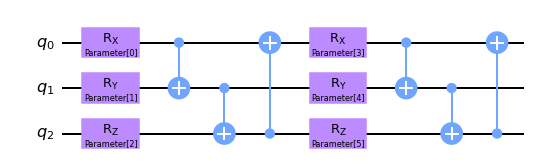

In [3]:
from qiskit.circuit import QuantumCircuit, ParameterVector

n = 3
qc = QuantumCircuit(n)

param_list = ParameterVector('Parameter', 2*n)

for i in range(len(param_list)//n):
    qc.rx(param_list[3*i], 0)
    qc.ry(param_list[3*i+1], 1)
    qc.rz(param_list[3*i+2], 2)

    qc.cnot(0, 1)
    qc.cnot(1, 2)
    qc.cnot(2, 0)

qc.draw(output='mpl')

### ハミルトニアンの定義

In [4]:
from qiskit.opflow import I, X, Y, Z
hamiltonian = Z ^ I ^ Y

### ハミルトニアンの期待値の計算

In [5]:
from qiskit.opflow import StateFn, AerPauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
pauli_basis = AerPauliExpectation().convert(expectation)

In [6]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 32768, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(params):
    value_dict = dict(zip(qc.parameters, params))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

In [7]:
def calc_gradient(params):
    gradient = np.zeros_like(params)
    for i in range(len(params)):
        shifted = params.copy()
        shifted[i] += np.pi/2
        forward = evaluate_expectation(shifted)

        shifted[i] -= np.pi
        backward = evaluate_expectation(shifted)

        gradient[i] = 0.5 * (forward - backward)
    return np.round(gradient, 10)

In [8]:
calc_gradient(input_param)

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.45534747,
        0.        ])

## Gradient Frameworkを利用する


In [9]:
from qiskit.opflow import Gradient

def calc_gradient_with_framework(params):
    state_grad = Gradient(grad_method="param_shift").convert(operator=expectation)
    value_dict = dict(zip(qc.parameters, params))
    result = state_grad.assign_parameters(value_dict).eval()
    return np.round(np.array(result).real, 10)


In [10]:
calc_gradient_with_framework(input_param)

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.45534747,
        0.        ])

## バージョン情報

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table